# 语义分割和数据集

我们做了图片分类 目标检测 

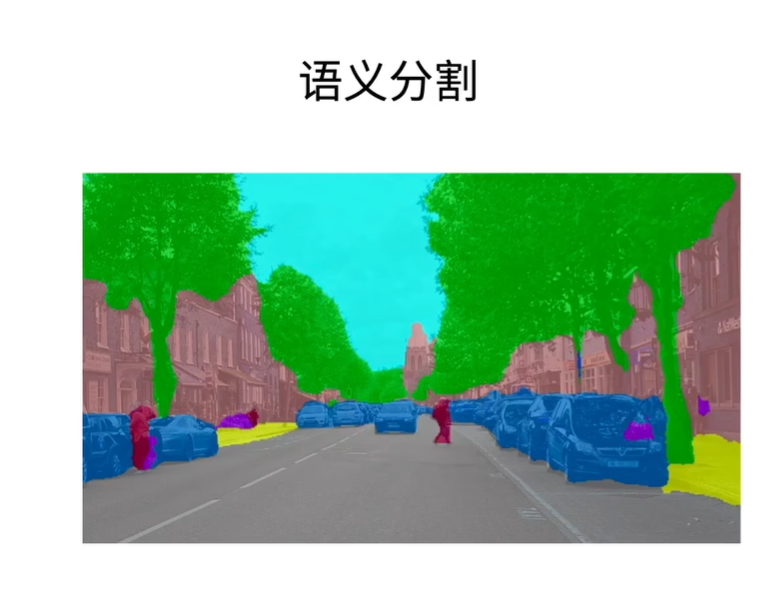

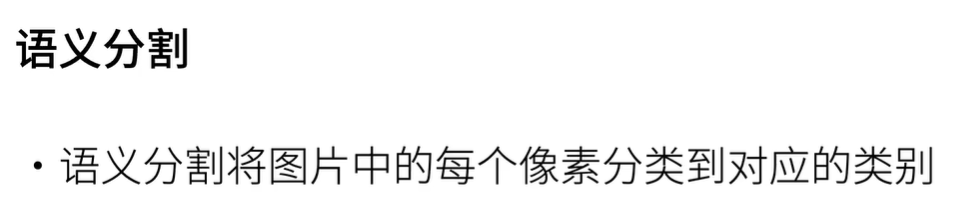
目标检测是找到物体在哪里并把它圈出来
目标检测问题中，我们一直使用方形边界框来标注和预测图像中的目标。 

与目标检测不同，语义分割可以识别并理解图像中每一个像素的内容：其语义区域的标注和预测是像素级的
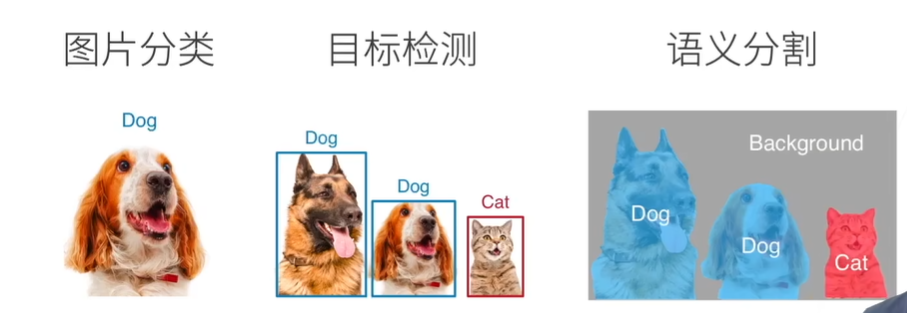
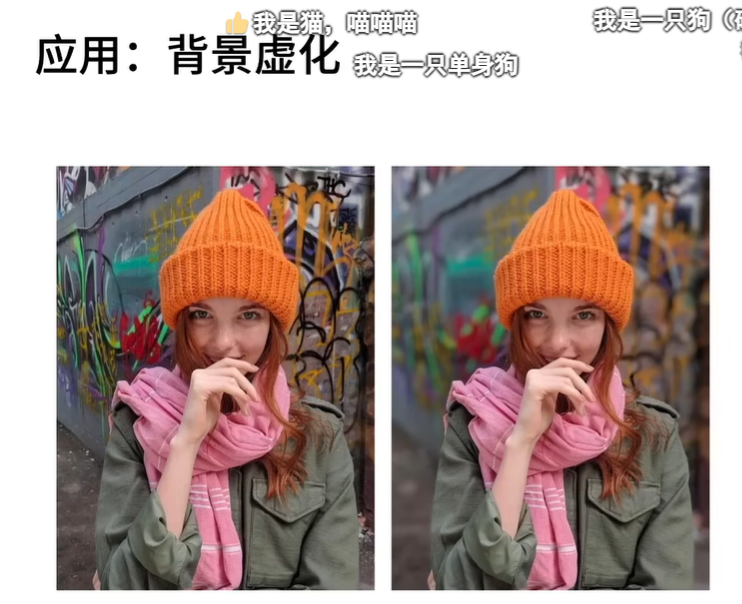
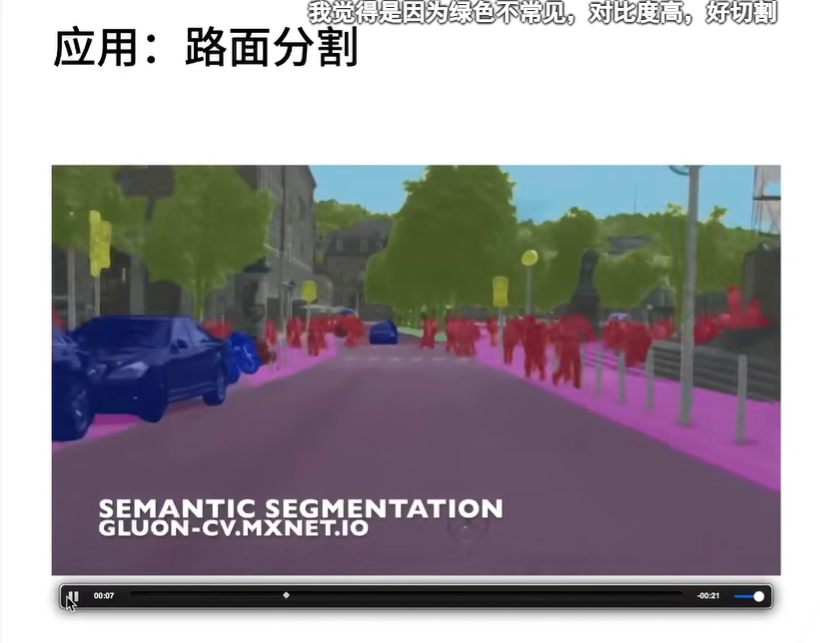
语义分割和实例分割的区别

实例分割会区分不同的分类 对每个类会做区分（是目标检测的进化版本）
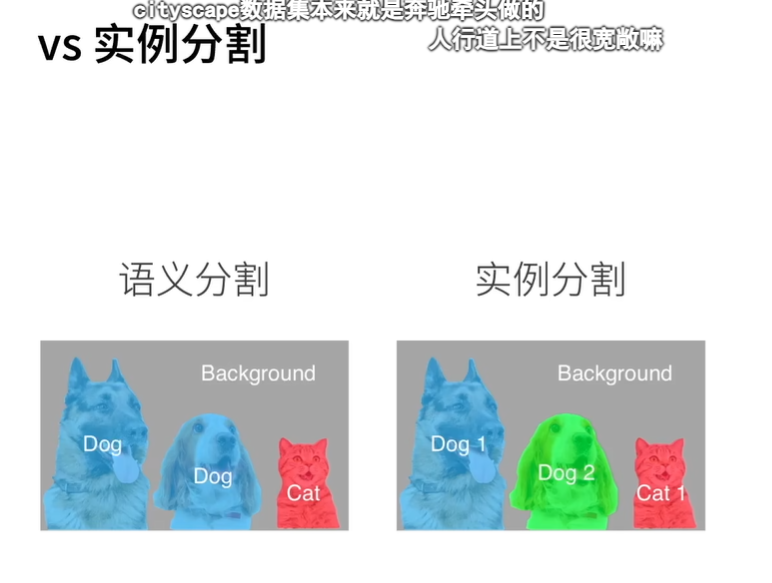

In [1]:
# 最重要的语义分割数据集之一Pascal VOC2012
%matplotlib inline
import os
import torch
import torchvision
from d2l import torch as d2l

In [2]:
#@save
#下载数据然后解压放在文件夹中


voc_dir = ('data/VOCdevkit/VOC2012/')

In [3]:
#@save
# 取 PASCAL VOC 数据集中的所有图像和相应的标注文件，并将它们存储在列表中
# voc_dir 是 VOC 数据集的根目录。
# is_train 参数决定读取的是训练集还是验证集。
def read_voc_images(voc_dir, is_train=True):
    """读取所有VOC图像并标注"""
    # 根据是否是训练集，选择相应的文件路径
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
                             
    # 读取图像的模式为RGB
    mode = torchvision.io.image.ImageReadMode.RGB
    
    # 打开包含图像文件名的文本文件
    with open(txt_fname, 'r') as f:
        images = f.read().split()  # 读取所有文件名
    
    features, labels = [], []  # 用于存储图像和标签的列表
    
    # 遍历每个文件名
    for i, fname in enumerate(images):
        # 读取并添加图像到features列表
        features.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'JPEGImages', f'{fname}.jpg')))
        
        # 读取并添加标签到labels列表
        labels.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'SegmentationClass', f'{fname}.png'), mode))
    
    # 返回图像和标签列表
    return features, labels

# 读取训练集的图像和标签
train_features, train_labels = read_voc_images(voc_dir, True)

In [4]:
train_features[0], train_labels[0]

(tensor([[[131, 131, 131,  ..., 182, 182, 182],
          [132, 132, 133,  ..., 183, 183, 182],
          [133, 133, 134,  ..., 183, 183, 182],
          ...,
          [  6,   5,   7,  ...,  16,  16,  16],
          [  5,   9,  12,  ...,  16,  17,  17],
          [  5,   6,  10,  ...,  16,  12,  17]],
 
         [[193, 193, 193,  ..., 232, 232, 232],
          [194, 194, 195,  ..., 233, 233, 232],
          [195, 195, 196,  ..., 233, 233, 232],
          ...,
          [ 15,  14,  13,  ...,  34,  34,  34],
          [ 14,  18,  17,  ...,  34,  35,  35],
          [ 15,  16,  18,  ...,  33,  29,  34]],
 
         [[208, 208, 208,  ..., 241, 241, 241],
          [209, 209, 210,  ..., 242, 242, 241],
          [210, 210, 211,  ..., 242, 242, 241],
          ...,
          [ 14,  13,  13,  ...,  38,  38,  38],
          [ 13,  17,  20,  ...,  38,  39,  39],
          [ 14,  15,  20,  ...,  40,  36,  41]]], dtype=torch.uint8),
 tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0

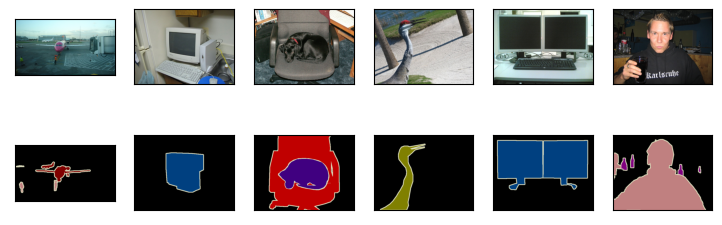

In [5]:
# 显示的图像数量 n
n = 6
# 这里将前 n 个训练图像和前 n 个标签图像合并到一个列表 imgs 中。
imgs = train_features[0:n] + train_labels[0:n]
# 图像张量的原始维度是 (C, H, W)，即通道在第一维，
# 而显示图像需要将通道放在最后一维 (H, W, C)，
# 因此需要使用 permute 函数进行维度转换。
imgs = [img.permute(1,2,0) for img in imgs]
d2l.show_images(imgs, 2, n);

In [6]:
#列举RGB颜色值和类名
#@save
# 每个RGB对应的类别是什么

VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

#@save
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [7]:
#@save
def voc_colormap2label():
    """构建从RGB到VOC类别索引的映射
    
    创建一个映射，将VOC数据集中每种颜色（RGB）映射到其对应的类别索引。
    返回一个张量，张量的索引是RGB颜色的唯一整数表示，值是对应的类别索引。
    """
    # 创建一个长度为256^3的张量，每个元素初始化为0，数据类型为long
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    
    # 遍历VOC_COLORMAP中的每种颜色和对应的类别索引
    for i, colormap in enumerate(VOC_COLORMAP):
        # 计算RGB颜色的唯一整数索引
        rgb_index = (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]
        # 将该索引位置的值设置为类别索引i
        colormap2label[rgb_index] = i
    
    return colormap2label

#@save
def voc_label_indices(colormap, colormap2label):
    """将VOC标签中的RGB值映射到它们的类别索引
    
    将标签图像中的RGB值转换为VOC数据集中定义的类别索引。
    
    参数:
    colormap (Tensor): 标签图像的RGB值，形状为(H, W, C)。
    colormap2label (Tensor): 从RGB颜色到类别索引的映射张量。
    
    返回:
    Tensor: 映射后的类别索引，形状为(H, W)。
    """
    # 将colormap的维度从(C, H, W)转换为(H, W, C)，并转换为numpy数组
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    
    # 计算每个像素的唯一整数索引
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 + colormap[:, :, 2])
    
    # 使用colormap2label映射RGB颜色到类别索引
    return colormap2label[idx]

In [8]:
# 在第一张样本图像中，飞机头部区域的类别索引为1，而背景索引为0
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

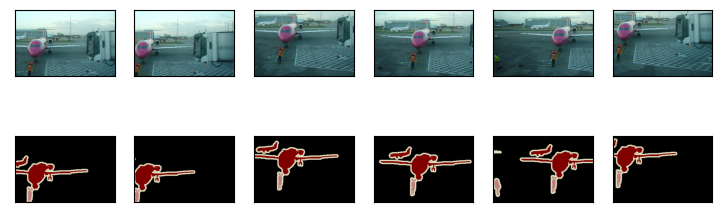

In [9]:
#@save
#注意对图像裁剪后也必须对标签也做裁剪

def voc_rand_crop(feature, label, height, width):
    """随机裁剪特征和标签图像
    
    对输入的特征图像和标签图像进行相同的随机裁剪，以保持图像和标签的对齐。
    
    参数:
    feature (Tensor): 输入的特征图像，通常是一个高维的张量。
    label (Tensor): 输入的标签图像，通常是一个高维的张量。
    height (int): 裁剪后的图像高度。
    width (int): 裁剪后的图像宽度。
    
    返回:
    Tuple: 裁剪后的特征图像和标签图像。
    """
    # 使用torchvision.transforms.RandomCrop.get_params来生成裁剪区域
    rect = torchvision.transforms.RandomCrop.get_params(
        feature, (height, width))
    
    # 根据生成的裁剪区域裁剪特征图像
    feature = torchvision.transforms.functional.crop(feature, *rect)
    # 根据生成的裁剪区域裁剪标签图像
    label = torchvision.transforms.functional.crop(label, *rect)
    
    return feature, label

# 创建一个空列表来存储裁剪后的图像
imgs = []
# 对每一个样本进行裁剪
for _ in range(n):
    # 随机裁剪特征图像和标签图像，并将裁剪后的图像添加到列表中
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)

# 重新排列图像的维度，从(C, H, W)到(H, W, C)
imgs = [img.permute(1, 2, 0) for img in imgs]

# 显示裁剪后的图像，使用d2l.show_images来可视化图像
d2l.show_images(imgs[::2] + imgs[1::2], 2, n)

In [10]:
#@save
#这是一个用于加载和处理 VOC 数据集的自定义数据集类。

class VOCSegDataset(torch.utils.data.Dataset):
    """一个用于加载VOC数据集的自定义数据集
    
    该数据集类用于处理VOC数据集，进行数据预处理和裁剪，为训练模型准备数据。

    参数:
    is_train (bool): 指示是否加载训练集数据。
    crop_size (tuple): 模型训练时的小批量是多少，裁剪图像的目标大小 (高度, 宽度)。
    voc_dir (str): VOC 数据集的目录路径。
    """

    def __init__(self, is_train, crop_size, voc_dir):
        # 图像标准化的转换
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.crop_size = crop_size
        # 读取VOC图像和标签
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        # 过滤和标准化图像
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        # 从RGB到VOC类别索引的映射
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        """标准化图像
        
        将图像像素值从[0, 255]范围映射到[0, 1]，然后进行标准化处理。
        
        参数:
        img (Tensor): 输入图像。

        返回:
        Tensor: 标准化后的图像。
        """
        return self.transform(img.float() / 255)

    def filter(self, imgs):
        """过滤尺寸不符合要求的图像
        
        只保留那些宽度和高度都大于等于裁剪尺寸的图像。
        
        参数:
        imgs (list): 图像列表。

        返回:
        list: 过滤后的图像列表。
        """
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]

    def __getitem__(self, idx):
        """获取数据集中的一个样本
        
        对图像和标签进行随机裁剪，并将标签转换为类别索引。
        
        参数:
        idx (int): 数据样本的索引。

        返回:
        Tuple: 裁剪后的特征图像和标签索引。
        """
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))

    def __len__(self):
        """返回数据集中样本的数量
        
        返回:
        int: 数据集中的样本数量。
        """
        return len(self.features)


In [11]:
#读取数据集
# 假设我们指定随机裁剪的输出图像的形状为320x480
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


In [12]:
batch_size = 64
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True,
                                    drop_last=True,
                                    num_workers=0)
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

torch.Size([64, 3, 320, 480])
torch.Size([64, 320, 480])


In [13]:
#@save
def load_data_voc(batch_size, crop_size):
    """加载VOC语义分割数据集"""
    voc_dir = d2l.download_extract('voc2012', os.path.join(
        'VOCdevkit', 'VOC2012'))
    num_workers = d2l.get_dataloader_workers()
    train_iter = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size,
        shuffle=True, drop_last=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        drop_last=True, num_workers=num_workers)
    return train_iter, test_iter